In [1]:
import pandas as pd
import numpy as np
train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
#test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
book_train = pd.read_parquet('../input/optiver-realized-volatility-prediction/book_train.parquet')
trade_train = pd.read_parquet('../input/optiver-realized-volatility-prediction/trade_train.parquet')
#book_test = pd.read_parquet('../input/optiver-realized-volatility-prediction/book_train.parquet')
#print(train.head(2))
#print(test.head(2))
#print(book_train.head(2))
#print(trade_train.head(2))
#print(trade_test.head(2))

In [2]:
print(train.head(2))

   stock_id  time_id    target
0         0        5  0.004136
1         0       11  0.001445


In [3]:
print(book_train.head(2))

   time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.001422    1.002301     1.00137    1.002353   
1        5                  1    1.001422    1.002301     1.00137    1.002353   

   bid_size1  ask_size1  bid_size2  ask_size2 stock_id  
0          3        226          2        100        0  
1          3        100          2        100        0  


In [4]:
print(trade_train.head(2))

   time_id  seconds_in_bucket     price  size  order_count stock_id
0        5                 21  1.002301   326           12        0
1        5                 46  1.002778   128            4        0


In [5]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

In [6]:
def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

In [7]:
# To calculate WAP and realized volatility per stock id and time id
def realized_volatility_per_time_id(file_path, prediction_column_name):
    #print(file_path)
    df_book_data = pd.read_parquet(file_path)
    df_book_data['wap'] =(df_book_data['bid_price1'] * df_book_data['ask_size1']+df_book_data['ask_price1'] * df_book_data['bid_size1'])  / (
                                      df_book_data['bid_size1']+ df_book_data[
                                  'ask_size1'])
    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    stock_id = file_path.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]

In [8]:
def past_realized_volatility_per_stock(list_file,prediction_column_name):
    df_past_realized = pd.DataFrame()
    for file in list_file:
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized

In [9]:
import os
import glob
list_order_book_file_train = glob.glob('/kaggle/input/optiver-realized-volatility-prediction/book_train.parquet/*')
df_past_realized_train = past_realized_volatility_per_stock(list_file=list_order_book_file_train,
                                                           prediction_column_name='pred')

In [10]:
list_order_book_file_test = glob.glob('/kaggle/input/optiver-realized-volatility-prediction/book_test.parquet/*')
df_past_realized_test = past_realized_volatility_per_stock(list_file=list_order_book_file_test,
                                                           prediction_column_name='test_past_vol')

In [11]:
df_past_realized_train.head()

,row_id,pred
0,97-5,0.007263
1,97-11,0.002919
2,97-16,0.003799
3,97-31,0.003753
4,97-62,0.004365


In [12]:
df_past_realized_test.head()

,row_id,test_past_vol
0,0-4,0.000294


In [13]:
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
#train = train[['row_id','target']]
df_joined = train.merge(df_past_realized_train[['row_id','pred']], on = ['row_id'], how = 'left')
df_joined.columns = ['stock_id', 'time_id', 'target', 'row_id', 'past_vol']
#df_joined.drop('row_id', axis=1, inplace=True)
#print(train.head())

In [14]:
df_joined.head()

,stock_id,time_id,target,row_id,past_vol
0,0,5,0.004136,0-5,0.004499
1,0,11,0.001445,0-11,0.001204
2,0,16,0.002168,0-16,0.002369
3,0,31,0.002195,0-31,0.002574
4,0,62,0.001747,0-62,0.001894


In [15]:
def trade_book_total(file_path, prediction_column_name):
    #print(file_path)
    df_trade_data = pd.read_parquet(file_path)
    df_trade_data['tot_price'] = df_trade_data['price'] * df_trade_data['size']
    df_total_trade_data =  pd.DataFrame(df_trade_data.groupby(['time_id']).sum('tot_price')).reset_index()
    df_total_trade_data = df_total_trade_data.rename(columns = {'tot_price':prediction_column_name})
    stock_id = file_path.split('=')[1]
    df_total_trade_data['row_id'] = df_total_trade_data['time_id'].apply(lambda x:f'{stock_id}-{x}')
    return df_total_trade_data [['row_id',prediction_column_name]]

In [16]:
def trade_book_total_value(list_file,prediction_column_name):
    df_trade_book = pd.DataFrame()
    for file in list_file:
        #print(file)
        df_trade_book = pd.concat([df_trade_book,trade_book_total(file, prediction_column_name)])
    return df_trade_book

In [17]:
import os
import glob
list_trade_book_file_train = glob.glob('/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/*')
df_past_realized_train_trade = trade_book_total_value(list_file=list_trade_book_file_train,
                                                           prediction_column_name='total_val')

In [18]:
list_trade_book_file_test = glob.glob('/kaggle/input/optiver-realized-volatility-prediction/trade_test.parquet/*')
df_past_realized_test_trade = trade_book_total_value(list_file=list_trade_book_file_test,
                                                           prediction_column_name='total_val')

In [19]:
df_past_realized_train_trade.head()

,row_id,total_val
0,97-5,3976.823730
1,97-11,1942.729980
2,97-16,5333.698730
3,97-31,4281.407227
4,97-62,2915.905273


In [20]:
df_past_realized_test_trade.head()

,row_id,total_val
0,0-4,201.011156


In [21]:
###train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
#train = train[['row_id','target']]
df_joined_new = df_joined.merge(df_past_realized_train_trade, on = ['row_id'], how = 'left')
df_joined_new.columns = ['stock_id', 'time_id', 'target', 'row_id','past_vol','past_trade_tot']
df_joined_new.drop('row_id', axis=1, inplace=True)
#print(train.head())

In [22]:
df_joined_new.head()

,stock_id,time_id,target,past_vol,past_trade_tot
0,0,5,0.004136,0.004499,3190.139160
1,0,11,0.001445,0.001204,1289.353394
2,0,16,0.002168,0.002369,2158.608887
3,0,31,0.002195,0.002574,1959.605469
4,0,62,0.001747,0.001894,1790.254517


In [23]:
df_joined_new.isnull().sum()

stock_id           0
time_id            0
target             0
past_vol           0
past_trade_tot    19
dtype: int64

In [24]:
df_joined_new.fillna(0, inplace=True)

In [25]:
df_joined_new.isnull().sum()

stock_id          0
time_id           0
target            0
past_vol          0
past_trade_tot    0
dtype: int64

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [27]:
np.random.seed(0) # to select same sample everytime
df_train, df_test = train_test_split(df_joined_new, train_size=0.7, test_size=0.3, random_state=42)

In [28]:
print(df_train.shape)
print(df_test.shape)

(300252, 5)
(128680, 5)


In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300252 entries, 148183 to 121958
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   stock_id        300252 non-null  int64  
 1   time_id         300252 non-null  int64  
 2   target          300252 non-null  float64
 3   past_vol        300252 non-null  float32
 4   past_trade_tot  300252 non-null  float32
dtypes: float32(2), float64(1), int64(2)
memory usage: 11.5 MB


In [30]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128680 entries, 58607 to 204608
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   stock_id        128680 non-null  int64  
 1   time_id         128680 non-null  int64  
 2   target          128680 non-null  float64
 3   past_vol        128680 non-null  float32
 4   past_trade_tot  128680 non-null  float32
dtypes: float32(2), float64(1), int64(2)
memory usage: 4.9 MB


In [31]:
scaler = MinMaxScaler()

In [32]:
#num_vars = ['stock_id', 'time_id', 'target', 'past_vol']
#df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [33]:
## Dividing into X & y sets for model building

y_train = df_train.pop('target')
X_train = df_train

In [34]:
X_train.isnull().sum()

stock_id          0
time_id           0
past_vol          0
past_trade_tot    0
dtype: int64

In [35]:
y_train.isnull().sum()

0

In [36]:
## Fitting the model

lm = LinearRegression()
lm.fit(X_train, y_train)
#print(X_train.info())
#print(y_train.info())

LinearRegression()

In [37]:
rfe = RFE(lm, 4)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=4)

In [38]:
list(zip(X_train.columns,rfe.support_, rfe.ranking_))

[('stock_id', True, 1),
 ('time_id', True, 1),
 ('past_vol', True, 1),
 ('past_trade_tot', True, 1)]

In [39]:
col = X_train.columns[rfe.support_]
col

Index(['stock_id', 'time_id', 'past_vol', 'past_trade_tot'], dtype='object')

In [40]:
X_train_rfe = X_train[col]

In [41]:
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,time_id,2.55
0,stock_id,2.51
2,past_vol,2.00
3,past_trade_tot,1.19


In [42]:
X_train_rfe

,stock_id,time_id,past_vol,past_trade_tot
148183,41,22126,0.001072,25413.822266
104510,30,9215,0.005446,2966.402832
390565,114,32186,0.024367,25286.845703
123863,35,11007,0.002135,46201.609375
276632,82,7316,0.005720,17465.380859
...,...,...,...,...
259178,76,21439,0.003456,7832.736816
365838,108,16733,0.001024,17715.046875
131932,37,14273,0.002124,40.079678
146867,41,11351,0.001252,126631.554688


In [43]:
## First model

# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_rfe)

## Running the model
lm1 = sm.OLS(y_train, X_train_lm).fit()

In [44]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                 2.451e+05
Date:                Fri, 13 Aug 2021   Prob (F-statistic):               0.00
Time:                        04:53:43   Log-Likelihood:             1.5423e+06
No. Observations:              300252   AIC:                        -3.085e+06
Df Residuals:                  300247   BIC:                        -3.085e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0009   7.52e-06    120.547      0.000       0.001       0.001
stock_id       -3.636e-07   6.99e-08     -5.200      0.000   -5.01e-07   -2.27e-07
time_id        -1.733e-09   2.77e-10     -6.258      0.000   -2.28e-09   -1.19e-09
past_vol           0.7200      0.001    988.924      0.000       0.719       0.721
past_trade_tot  -7.34e-10   3.67e-11    -19.982      0.000   -8.06e-10   -6.62e-10
==============================================================================
Omnibus:                   183348.845   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         35582853.164
Skew:                           1.882   Prob(JB):                         0.00
Kurtosis:                      56.198   Cond. No.                     2.19e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
y_train_pred = lm1.predict(X_train_lm)

In [46]:
X_train_lm

,const,stock_id,time_id,past_vol,past_trade_tot
148183,1.0,41,22126,0.001072,25413.822266
104510,1.0,30,9215,0.005446,2966.402832
390565,1.0,114,32186,0.024367,25286.845703
123863,1.0,35,11007,0.002135,46201.609375
276632,1.0,82,7316,0.005720,17465.380859
...,...,...,...,...,...
259178,1.0,76,21439,0.003456,7832.736816
365838,1.0,108,16733,0.001024,17715.046875
131932,1.0,37,14273,0.002124,40.079678
146867,1.0,41,11351,0.001252,126631.554688


In [47]:
y_train_pred

148183    0.001607
104510    0.004799
390565    0.018335
123863    0.002378
276632    0.004970
            ...   
259178    0.003325
365838    0.001563
131932    0.002398
146867    0.001681
121958    0.001628
Length: 300252, dtype: float64

Text(0.5, 0, 'Errors')

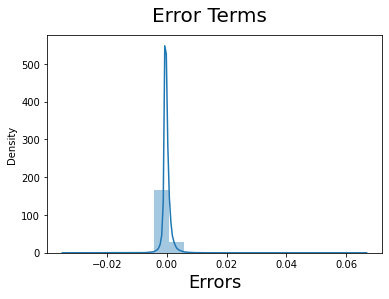

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)

In [49]:
#num_vars = ['stock_id', 'time_id', 'target', 'past_vol']
#df_test[num_vars] = scaler.fit_transform(df_test[num_vars])

In [50]:
y_test = df_test.pop('target')
X_test = df_test

In [51]:
X_test.head()

,stock_id,time_id,past_vol,past_trade_tot
58607,16,9787,0.007143,4902.535156
356864,105,5773,0.002404,16494.558594
197966,58,22076,0.002623,3632.061279
261134,77,5817,0.006993,131253.187500
193238,56,14572,0.002564,15650.796875


In [52]:
X_test.isnull().sum()

stock_id          0
time_id           0
past_vol          0
past_trade_tot    0
dtype: int64

In [53]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
#X_test_new = X_test[X_train.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test)

In [54]:
X_test_new.head()

,const,stock_id,time_id,past_vol,past_trade_tot
58607,1.0,16,9787,0.007143,4902.535156
356864,1.0,105,5773,0.002404,16494.558594
197966,1.0,58,22076,0.002623,3632.061279
261134,1.0,77,5817,0.006993,131253.187500
193238,1.0,56,14572,0.002564,15650.796875


In [55]:
X_test_new.isnull().sum()

const             0
stock_id          0
time_id           0
past_vol          0
past_trade_tot    0
dtype: int64

In [56]:
y_test.isnull().sum()

0

In [57]:
y_test_pred = lm1.predict(X_test_new)

In [58]:
y_test_pred.isnull().sum()

0

Text(0, 0.5, 'y_test_pred')

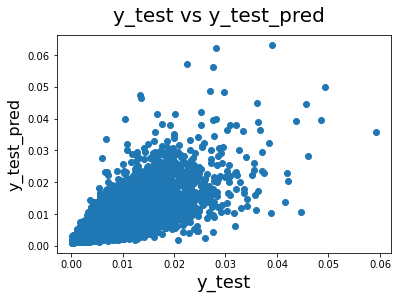

In [59]:
# Plotting y_test and y_pred to understand the spread.
import matplotlib.pyplot as plt
fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_test_pred', fontsize=16)   

In [60]:
r2_score(y_true=y_test, y_pred=y_test_pred)

0.7596589982138854

In [61]:
book_test = pd.read_parquet('../input/optiver-realized-volatility-prediction/book_test.parquet')
print(book_test)

   time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        4                  0    1.000049    1.000590    0.999656    1.000639   
1        4                  1    1.000049    1.000590    0.999656    1.000639   
2        4                  5    1.000049    1.000639    0.999656    1.000885   

   bid_size1  ask_size1  bid_size2  ask_size2 stock_id  
0         91        100        100         24        0  
1         91        100        100         20        0  
2        290         20        101         15        0  


In [62]:
trade_test = pd.read_parquet('../input/optiver-realized-volatility-prediction/trade_test.parquet')
trade_test

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,4,7,1.000344,1,1,0
1,4,24,1.000049,100,7,0
2,4,27,1.000059,100,3,0


In [63]:
print(df_past_realized_test)

  row_id  test_past_vol
0    0-4       0.000294


In [64]:
test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
test

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [65]:
df_past_realized_test_trade.head()

,row_id,total_val
0,0-4,201.011156


In [66]:
df_past_realized_test.head()

,row_id,test_past_vol
0,0-4,0.000294


In [67]:
test.head(2)

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32


In [68]:
#test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
df_test_joined = test.merge(df_past_realized_test[['row_id','test_past_vol']], on = ['row_id'], how = 'left')
df_test_joined.columns = ['stock_id', 'time_id', 'row_id', 'past_vol']
#df_test_joined.drop('row_id', axis=1, inplace=True)
print(df_test_joined.head())

   stock_id  time_id row_id  past_vol
0         0        4    0-4  0.000294
1         0       32   0-32       NaN
2         0       34   0-34       NaN


In [69]:
###train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
#train = train[['row_id','target']]
df_test_joined_new = df_test_joined.merge(df_past_realized_test_trade, on = ['row_id'], how = 'left')
df_test_joined_new.columns = ['stock_id', 'time_id', 'row_id','past_vol','test_past_vol']
df_test_joined_new.drop('row_id', axis=1, inplace=True)
#print(train.head())

In [70]:
#num_vars = ['stock_id', 'time_id', 'test_past_vol']
#df_test_joined[num_vars] = scaler.fit_transform(df_test_joined[num_vars])
df_test_joined_new

,stock_id,time_id,past_vol,test_past_vol
0,0,4,0.000294,201.011156
1,0,32,NaN,NaN
2,0,34,NaN,NaN


In [71]:
X_test_joined = df_test_joined_new

In [72]:
X_test_joined = sm.add_constant(df_test_joined_new)
#print(df_test_joined.shape)
print(X_test_joined)

   const  stock_id  time_id  past_vol  test_past_vol
0    1.0         0        4  0.000294     201.011156
1    1.0         0       32       NaN            NaN
2    1.0         0       34       NaN            NaN


In [73]:
X_test_joined.dropna(axis=0, inplace=True)
X_test_joined

,const,stock_id,time_id,past_vol,test_past_vol
0,1.0,0,4,0.000294,201.011156


In [74]:
#X_test_joined = sm.add_constant(X_test_joined)
y_test_joined_pred = lm1.predict(X_test_joined)

In [75]:
y_test_joined_pred

0    0.001118
dtype: float64

In [76]:
results = pd.concat([df_test_joined_new, y_test_joined_pred], axis=1)
results['row_id'] = results['stock_id'].astype(str) + '-' + results['time_id'].astype(str)
results.drop(['stock_id', 'time_id', 'past_vol', 'test_past_vol'], axis=1, inplace=True)
results.columns = ['target', 'row_id']
results = results[['row_id', 'target']]
results_final = results.fillna(0)
results_final

,row_id,target
0,0-4,0.001118
1,0-32,0.000000
2,0-34,0.000000


In [77]:
results_final.to_csv('submission.csv',index = False)